In [2]:
## Load the packages

using MAT, Statistics, LinearAlgebra, Logging

Logging.disable_logging(Logging.Warn)

pwd()

"/Users/shuvomoy_das_gupta/My Drive/GitHub/NCG-PEP-code/Miscellaneous/Julia_code_for_Figure_1"

In [3]:
## All the functions
# =================

## ELS function 

function ELS(x0, dir, func, init_step)
    alpha = init_step
    increase = 2
    x = x0 - alpha * dir
    _, g = func(x)
    # find upper bound on stepsize
    while dot(dir, g) > 0
        alpha *= increase
        x = x0 - alpha * dir
        _, g = func(x)
    end
    if alpha > init_step
        alpha_low = init_step
        alpha_sup = alpha
    else
        alpha_low = 0
        alpha_sup = init_step
    end

    eps = 1e-7
    while abs(alpha_sup - alpha_low) > eps
        alpha = 1/2 * (alpha_sup + alpha_low)
        x = x0 - alpha * dir
        _, g = func(x)
        if dot(dir, g) < 0
            alpha_sup = alpha
        else
            alpha_low = alpha
        end
    end
    alpha = 1/2 * (alpha_sup + alpha_low)
    out = x0 - alpha * dir

    return out
end


## FISTA_LS function 

function FISTA_LS(x0, Nmax, func, L, reg)
    x = zeros(size(x0, 1), Nmax + 2)
    g = zeros(size(x0, 1), Nmax + 2)
    f = zeros(1, Nmax + 2)
    nbmiss = zeros(1, Nmax + 2)
    nbmiss_m = zeros(1, Nmax + 2)

    q = reg / L

    x[:, 1] = x0
    x[:, 2] = x0
    f[1], g[:, 1], nbmiss[1] = func(x0); nbmiss_m[1] = nbmiss[1]
    f[2], g[:, 2], nbmiss[2] = func(x0); nbmiss_m[2] = min(nbmiss[2], nbmiss_m[1])
    A = zeros(Nmax + 2, 1)
    A[2] = 1 / (1 - q)

    y = x0
    for i = 1:Nmax
        A[2 + i] = (1 + 2 * A[1 + i] + sqrt(4 * A[1 + i] + 4 * q * A[1 + i]^2 + 1)) / 2 / (1 - q)
        beta = (A[2 + i] - A[1 + i]) * (A[1 + i] * (1 - q) - A[i] - 1) / (A[2 + i] * (2 * q * A[1 + i] + 1) - q * A[1 + i]^2)
        _, gy = func(y)

        x[:, i + 2] = ELS(y, gy, func, 1)  # x[:, i + 2] = y - gy / L; # gradient step
        f[i + 2], g[:, i + 2], nbmiss[i + 2] = func(x[:, i + 2])
        nbmiss_m[i + 2] = min(nbmiss_m[i + 1], nbmiss[i + 2])
        y = x[:, i + 2] + beta * (x[:, i + 2] - x[:, i + 1])
    end

    return x, f, g, nbmiss, nbmiss_m
end

## ISTA_LS function 

function ISTA_LS(x0, Nmax, func, L)
    x = zeros(size(x0, 1), Nmax + 2)
    g = zeros(size(x0, 1), Nmax + 2)
    f = zeros(1, Nmax + 2)
    nbmiss = zeros(1, Nmax + 2)
    nbmiss_m = zeros(1, Nmax + 2)

    x[:, 1] = x0
    x[:, 2] = x0
    f[1], g[:, 1], nbmiss[1] = func(x0)
    nbmiss_m[1] = nbmiss[1]
    f[2], g[:, 2], nbmiss[2] = func(x0)
    nbmiss_m[2] = min(nbmiss[2], nbmiss_m[1])
    y = x0
    for i = 1:Nmax
        _, gy = func(y)
        # x[:, i+2] = y - gy / L # gradient step
        x[:, i+2] = ELS(y, gy, func, 1)  # Assume ELS is defined elsewhere
        f[i+2], g[:, i+2], nbmiss[i+2] = func(x[:, i+2])
        nbmiss_m[i+2] = min(nbmiss_m[i+1], nbmiss[i+2])
        y = x[:, i+2]
    end

    return x, f, g, nbmiss, nbmiss_m
end


## NCG_ref function 

function NCG_ref(x0, Nmax, func, eta, transfo, L, xref)
    x = zeros(size(x0, 1), Nmax + 2)
    g = zeros(size(x0, 1), Nmax + 2)
    f = zeros(1, Nmax + 2)
    dist = zeros(1, Nmax + 2)
    nbmiss = zeros(1, Nmax + 2)
    nbmiss_m = zeros(1, Nmax + 2)

    x[:, 1] = x0
    _, gy = func(x0)
    dir = gy
    x[:, 2] = ELS(x0, dir, func, 1)  # Assume ELS is defined elsewhere
    dist[1] = norm(x0 - xref)
    dist[2] = norm(x0 - xref)

    f[1], g[:, 1], nbmiss[1] = func(x0)
    nbmiss_m[1] = nbmiss[1]
    f[2], g[:, 2], nbmiss[2] = func(x0)
    nbmiss_m[2] = min(nbmiss[2], nbmiss_m[1])

    y = x0
    for i = 1:Nmax
        gy_old = gy
        _, gy = func(x[:, i + 1])
        beta = transfo((gy' * gy - eta * gy' * gy_old) / (gy_old' * gy_old))
        dir = gy + beta * dir
        x[:, i + 2] = ELS(x[:, i + 1], dir, func, 1)
        f[i + 2], g[:, i + 2], nbmiss[i + 2] = func(x[:, i + 2])
        nbmiss_m[i + 2] = min(nbmiss_m[i + 1], nbmiss[i + 2])
        dist[i + 2] = norm(x[:, i + 2] - xref)
    end
    theory = L / 2 ./ (1 .+ 0 .* (1:(Nmax + 1)))

    return x, f, g, nbmiss, nbmiss_m, theory, dist
end

## LogisticL function 

function LogisticL(X, a, reg)
    n = size(X, 2) # number of samples
    m = size(X, 1) # number of features

    nbMiss(xx) = sum(X' * xx .<= 0)

    grad = zeros(m)
    func = 0.0
    for i = 1:n
        grad .+= (-X[:, i]) / (1 + exp(dot(X[:, i], a))) + reg * a
        func += log(1 + exp(-dot(X[:, i], a))) + reg / 2 * dot(a, a)
    end
    grad = grad ./ n
    func = func / n
    nbMissf = nbMiss(a)

    return func, grad, nbMissf
end

## NCG function

function NCG(x0, Nmax, func, eta, transfo)
    x = zeros(size(x0, 1), Nmax + 2)
    g = zeros(size(x0, 1), Nmax + 2)
    f = zeros(1, Nmax + 2)
    nbmiss = zeros(1, Nmax + 2)
    nbmiss_m = zeros(1, Nmax + 2)

    x[:, 1] = x0
    _, gy = func(x0)
    dir = gy
    x[:, 2] = ELS(x0, dir, func, 1)  # Assume ELS is defined elsewhere

    f[1], g[:, 1], nbmiss[1] = func(x0)
    nbmiss_m[1] = nbmiss[1]
    f[2], g[:, 2], nbmiss[2] = func(x0)
    nbmiss_m[2] = min(nbmiss[2], nbmiss_m[1])

    y = x0
    for i = 1:Nmax
        gy_old = gy
        _, gy = func(x[:, i + 1])
        beta = transfo((gy' * gy - eta * gy' * gy_old) / (gy_old' * gy_old))
        dir = gy + beta * dir
        x[:, i + 2] = ELS(x[:, i + 1], dir, func, 1)
        f[i + 2], g[:, i + 2], nbmiss[i + 2] = func(x[:, i + 2])
        nbmiss_m[i + 2] = min(nbmiss_m[i + 1], nbmiss[i + 2])
    end

    return x, f, g, nbmiss, nbmiss_m
end


## OGM_LS function

function OGM_LS(x0, Nmax, func)
    x = zeros(size(x0, 1), Nmax + 2)
    g = zeros(size(x0, 1), Nmax + 2)
    f = zeros(1, Nmax + 2)
    nbmiss = zeros(1, Nmax + 2)
    nbmiss_m = zeros(1, Nmax + 2)

    x[:, 1] = x0
    x[:, 2] = x0
    f[1], g[:, 1], nbmiss[1] = func(x0)
    nbmiss_m[1] = nbmiss[1]
    f[2], g[:, 2], nbmiss[2] = func(x0)
    nbmiss_m[2] = min(nbmiss[2], nbmiss_m[1])
    t = zeros(Nmax + 1)
    t[1] = 1
    y = x0
    acc = zeros(eltype(y), size(y))

    for i = 1:Nmax
        t[i + 1] = (1 + sqrt(4 * t[i]^2 + 1)) / 2
        if i == Nmax
            t[i + 1] = (1 + sqrt(8 * t[i]^2 + 1)) / 2
        end
        
        y = (1 - 1 / t[i + 1]) * x[:, i + 1] + 1 / t[i + 1] * x0
        _, gy = func(y)
        
        acc += t[i] * gy
        dir = (1 - 1 / t[i + 1]) * gy + 2 / t[i + 1] * acc
        x[:, i + 2] = ELS(y, dir, func, 1)  # Assume ELS is defined elsewhere
        f[i + 2], g[:, i + 2], nbmiss[i + 2] = func(x[:, i + 2])
        nbmiss_m[i + 2] = min(nbmiss_m[i + 1], nbmiss[i + 2])
    end

    return x, f, g, nbmiss, nbmiss_m
end

OGM_LS (generic function with 1 method)

In [4]:
## Load the dataset and construct the matrices
# ============================================

vars = matread("sonar.mat")

A1 = vars["A1"]

A2 = vars["A2"]

reg = 1e-4 # or 0, this is the regularization

## Time to form matrix X

n1 = size(A1,1)

n2 = size(A2,1)

m  = size(A1,2)+1

X  = zeros(n1+n2,m) 

nb_meas = n1+n2

nb_categ= m-1

# normalization to be done or not

normalization = 1

if normalization == 1
    mean_comp = zeros(1,nb_categ)
    std_comp = zeros(1,nb_categ)
    for categ = 1:nb_categ
        mean_comp[categ] = (sum(A1[:,categ])+sum(A2[:,categ]))/nb_meas
        std_comp[categ] = 1 # | sqrt((sum((A1[:,categ]-mean(categ)).^2)+sum((A2[:,categ]-mean(categ)).^2))/nb_meas); if we want to rescale
        A1[:,categ] = (A1[:,categ] .- mean_comp[categ])/std_comp[categ]
        A2[:,categ] = (A2[:,categ] .- mean_comp[categ])/std_comp[categ]
    end
end

for i = 1:n1
    X[i,:] = [A1[i,:]; 1]
end

for i = 1:n2
    X[n1+i,:] = -1 .* [A2[i,:]; 1]
end

X = transpose(X)

L = 1/4 * maximum(diag(X' * X))

func = a -> LogisticL(X, a, reg)
_, _, miss = func(zeros(m))

(0.6931471805599465, [0.0031086654031065118, 0.0037930011094674584, 0.0036755986501479303, 0.005803624260355035, 0.006143909485946743, 0.0038923492973372787, 0.003528478642751483, 0.0080226285133136, 0.018938845229289937, 0.022820365661982242  …  0.0013839358357988164, 0.0004984906619822479, 0.0006637689534023671, 0.00033734282544378724, 0.00036922383505917183, 2.685835798816375e-6, 0.0005930612056213015, 0.0004024546967455624, 0.0002254784578402365, 0.03365384615384615], 208)

In [5]:
## Time to run the code

Nmax = 1000
x0 = zeros(m)

x1, f1, g1, nbmiss1, nbmiss1_m = ISTA_LS(x0, Nmax, func, L)
x2, f2, g2, nbmiss2, nbmiss2_m = FISTA_LS(x0, Nmax, func, L, 0)
x3, f3, g3, nbmiss3, nbmiss3_m = FISTA_LS(x0, Nmax, func, L, reg)
x4, f4, g4, nbmiss4, nbmiss4_m = OGM_LS(x0, Nmax, func)

eta = 1
transfo = x -> x
x5, f5, g5, nbmiss5, nbmiss5_m = NCG(x0, Nmax, func, eta, transfo)
eta = 0
x6, f6, g6, nbmiss6, nbmiss6_m = NCG(x0, Nmax, func, eta, transfo)
eta = 1
transfo = x -> max(0, x)
x7, f7, g7, nbmiss7, nbmiss7_m = NCG(x0, Nmax, func, eta, transfo)

if reg > 0
    n_find_opt = 1500
    eta = 1
    transfo = x -> x
    xREF, fREF, gREF, nbmissREF, nbmissREF_m = NCG(x0, n_find_opt, func, eta, transfo)
    best_f = minimum([minimum(f1), minimum(f2), minimum(f3), minimum(f4), minimum(f5), minimum(f6), minimum(f7), minimum(fREF)])
else
    best_f = 0
end

0.32642801624000845

In [6]:
## Time to plot the results

using Plots

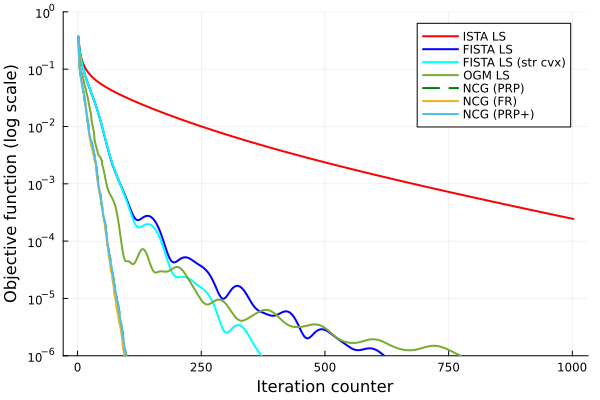

In [7]:
## subplot 1 
# =========
plot()

p1 = plot(1:Nmax+2, vec(f1 .- best_f), yaxis = :log, line = (:red, 2), label = "ISTA LS", xlabel = "Iteration counter", ylabel = "Objective function (log scale)")

plot!(1:Nmax+2, vec(f2 .- best_f), yaxis = :log, line = (:blue, 2), label = "FISTA LS")

plot!(1:Nmax+2, vec(f3 .- best_f), yaxis = :log, line = (:cyan, 2), label = "FISTA LS (str cvx)")

plot!(1:Nmax+2, vec(f4 .- best_f), yaxis = :log, line = (2, :solid, RGB(0.4660, 0.6740, 0.1880)), label = "OGM LS")

plot!(1:Nmax+2, vec(f5 .- best_f), yaxis=(:log10, [10^(-6), 1]), line = (:green, :dash, 2), label = "NCG (PRP)")

plot!(1:Nmax+2, vec(f6 .- best_f), yaxis=(:log10, [10^(-6), 1]), line = (2, :solid, RGB(0.9290, 0.6940, 0.1250)), label = "NCG (FR)")

plot!(1:Nmax+2, vec(f7 .- best_f), yaxis=(:log10, [10^(-6), 1]), line = (2, :solid, RGB(0.3010, 0.7450, 0.9330)), label = "NCG (PRP+)")

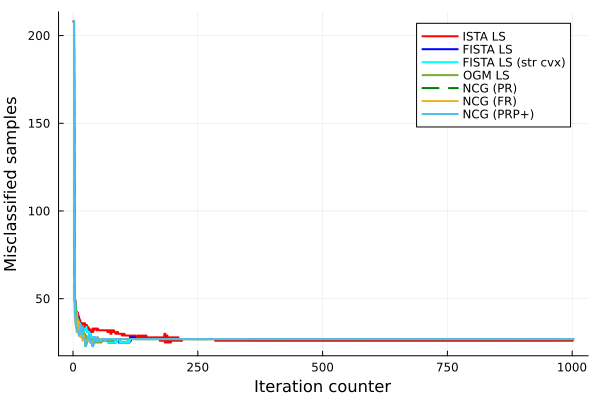

In [8]:
## subplot 2
# ==========

plot()

p2 = plot(1:Nmax+2, vec(nbmiss1), line = (:red, 2), label = "ISTA LS", xlabel = "Iteration counter", ylabel = "Misclassified samples")

plot!(1:Nmax+2, vec(nbmiss2), line = (:blue, 2), label = "FISTA LS")

plot!(1:Nmax+2, vec(nbmiss3), line = (:cyan, 2), label = "FISTA LS (str cvx)")

plot!(1:Nmax+2, vec(nbmiss4), line = (2, :solid, RGB(0.4660, 0.6740, 0.1880)), label = "OGM LS")

plot!(1:Nmax+2, vec(nbmiss5), line = (:green, :dash, 2), label = "NCG (PR)")

plot!(1:Nmax+2, vec(nbmiss6), line = (2, :solid, RGB(0.9290, 0.6940, 0.1250)), label = "NCG (FR)")

plot!(1:Nmax+2, vec(nbmiss7), line = (2, :solid, RGB(0.3010, 0.7450, 0.9330)), label = "NCG (PRP+)")

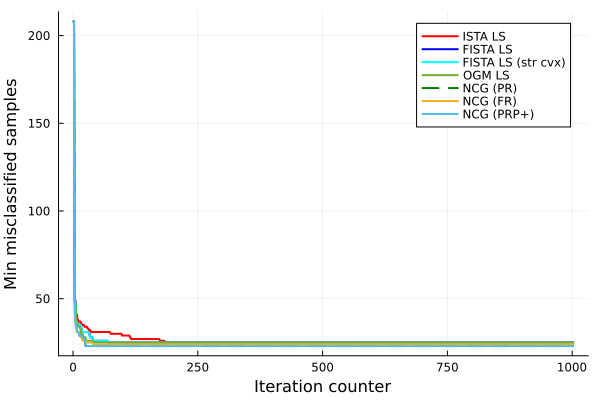

In [9]:
## subplot 3
# ==========

plot()

p3 = plot(1:Nmax+2, vec(nbmiss1_m), line = (:red, 2), label = "ISTA LS", xlabel = "Iteration counter", ylabel = "Min misclassified samples")
plot!(1:Nmax+2, vec(nbmiss2_m), line = (:blue, 2), label = "FISTA LS")
plot!(1:Nmax+2, vec(nbmiss3_m), line = (:cyan, 2), label = "FISTA LS (str cvx)")
plot!(1:Nmax+2, vec(nbmiss4_m), line = (2, :solid, RGB(0.4660, 0.6740, 0.1880)), label = "OGM LS")
plot!(1:Nmax+2, vec(nbmiss5_m), line = (:green, :dash, 2), label = "NCG (PR)")
plot!(1:Nmax+2, vec(nbmiss6_m), line = (2, :solid, RGB(0.9290, 0.6940, 0.1250)), label = "NCG (FR)")
plot!(1:Nmax+2, vec(nbmiss7_m), line = (2, :solid, RGB(0.3010, 0.7450, 0.9330)), label = "NCG (PRP+)")